## Machine Learning training

### Import libraries

In [2]:
import os
import sys
import pandas as pd

### Import dataset

In [3]:
project_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_path not in sys.path:
    sys.path.append(project_path)

In [4]:
matthews_df = os.path.join(project_path, "data", "final", "matthews_auston_final.csv")
df = pd.read_csv(matthews_df)

### Random Forest

Resources: [[1](https://arxiv.org/pdf/1407.7502)] [[2](https://www.stat.cmu.edu/~larry/%3Dsml/forests.pdf?utm_source=chatgpt.com)] [[3](https://datajobs.com/data-science-repo/Random-Forest-%5BLiaw-and-Weiner%5D.pdf?utm_source=chatgpt.com)] [[4](https://www.datacamp.com/tutorial/random-forests-classifier-python?utm_source=chatgpt.com)] [[5](https://arxiv.org/pdf/1511.05741)]

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [6]:
df_rf = df.copy() 

# Date
df_rf["gameDate"] = df["gameDate"].astype(str).str[:8]
df_rf["gameDate"] = pd.to_datetime(df_rf["gameDate"], format='%Y%m%d')
df_rf = df_rf.sort_values("gameDate")
df_rf["days_since_last_game"] = df_rf["gameDate"].diff().dt.days.fillna(0)
df_rf = df_rf.drop(["gameDate"], axis=1)

# New features
df_rf["target"] = df_rf["gameScore"].shift(-1)
df_rf["goal_last_1"] = df_rf["gameScore"].shift(1)
df_rf["goal_last_3_avg"] = df_rf["gameScore"].shift(1).rolling(window=3).mean()
df_rf["goal_last_5_avg"] = df_rf["gameScore"].shift(1).rolling(window=5).mean()

df_rf = df_rf.dropna()

In [7]:
# Model
X = df_rf.drop(["target"], axis=1)
y = df_rf["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    oob_score=True
)

In [8]:
rf.fit(X_train, y_train)

print(f'Out-of-Bag Score: {rf.oob_score_}')

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

last_game = X.iloc[[-1]]
game_score_pred = rf.predict(last_game)
print("Prediction Game Score next game:", round(game_score_pred[0], 3))

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

Out-of-Bag Score: -0.012839619556824111
RMSE: 1.0215896872683217
Prediction Game Score next game: 1.347

Feature importances:
goal_last_5_avg                  0.009767
timeOnBench_all                  0.006987
goal_last_3_avg                  0.006439
OffIce_A_shotAttempts_all        0.006328
icetime_all                      0.005994
                                   ...   
xGoalsForAfterShifts_5on4        0.000000
I_F_flurryAdjustedxGoals_4on5    0.000000
I_F_dZoneGiveaways_5on4          0.000000
I_F_dZoneGiveaways_4on5          0.000000
I_F_blockedShotAttempts_4on5     0.000000
Length: 687, dtype: float64


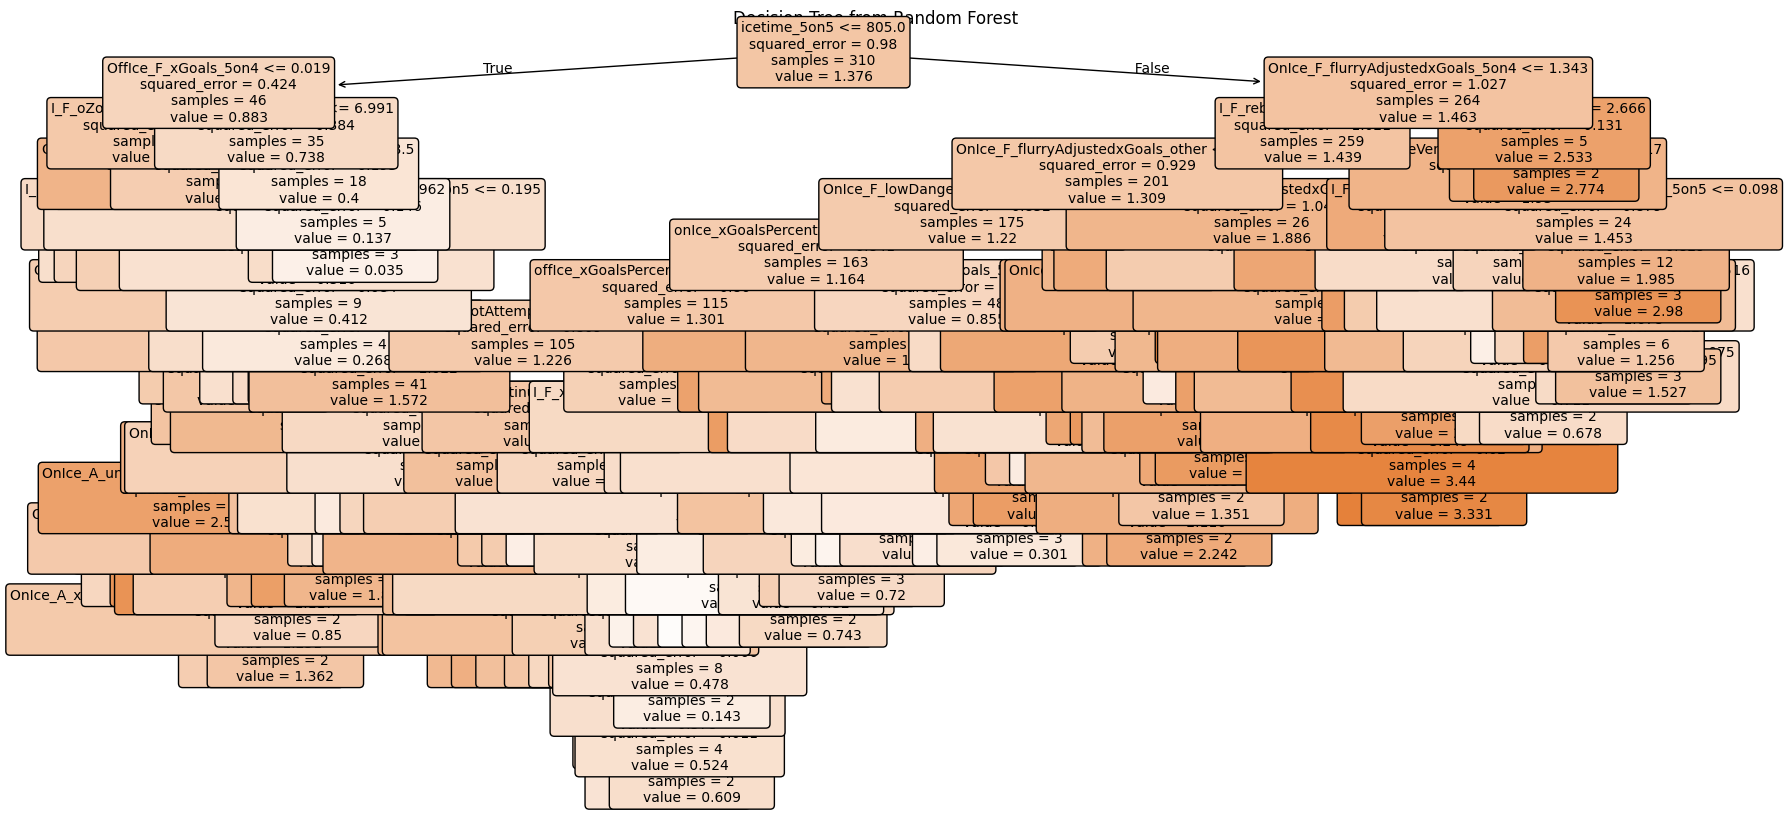

In [9]:
tree_to_plot = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df_rf.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

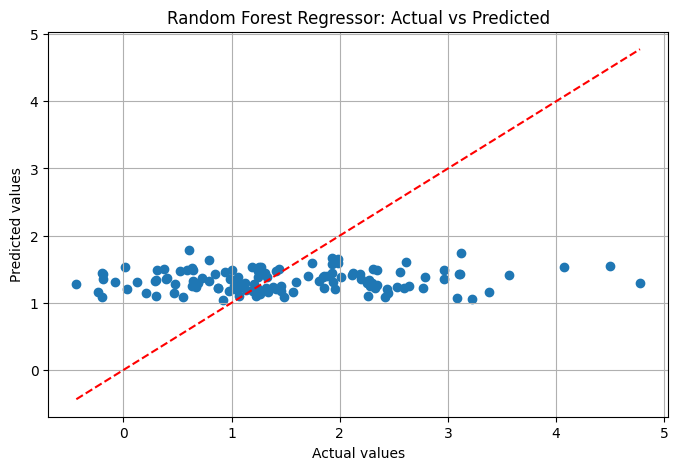

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Random Forest Regressor: Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid()
plt.show()